In [2]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

from downloaddata import fetch_data_all
import numpy as np
inputDir = 'data/train/Amsterdam/101'
outputDir = 'output'

ERROR:root:File `'update_path_to_download_script.py'` not found.


# Load the image 
Binary threshold between 800 - 100000

In [2]:
# Load the image
flairImage = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR.nii.gz'))
# Binary threshold between 800 - 100000
resultImage = sitk.BinaryThreshold(flairImage, lowerThreshold=800, upperThreshold=100000)
sitk.WriteImage(resultImage, os.path.join(outputDir, 'result.nii.gz'))

In [3]:
imgT1Original = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR.nii.gz'))
imgT2Original = sitk.ReadImage(os.path.join(inputDir, 'orig', 'T1.nii.gz'))

In [4]:
len(flairImage) / flairImage.GetHeight() / flairImage.GetDepth()

132.0

In [5]:
flairImage.GetHeight(), flairImage.GetDepth(), flairImage.GetNumberOfPixels()

(256, 83, 2804736)

In [6]:
single_img_1d.ravel()

NameError: name 'single_img_1d' is not defined

In [7]:
single_img = sitk.GetArrayFromImage(flairImage[:, :, 45])
single_img_1d = single_img.reshape((1, single_img.shape[0]*single_img.shape[1])).ravel()

(array([13402.,  3675.,  2225.,  1652.,  4415.,  4774.,  2769.,   710.,
          133.,    37.]),
 array([   0.,  130.,  260.,  390.,  520.,  650.,  780.,  910., 1040.,
        1170., 1300.]),
 <a list of 10 Patch objects>)

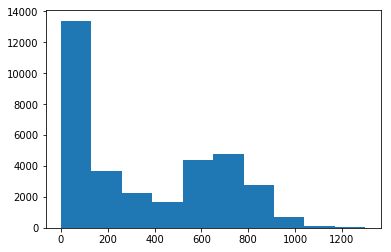

In [8]:
plt.hist(single_img_1d)

In [9]:
for i in range(flairImage.GetDepth()):
    print(flairImage[i].GetSize())
    break

(256, 83)


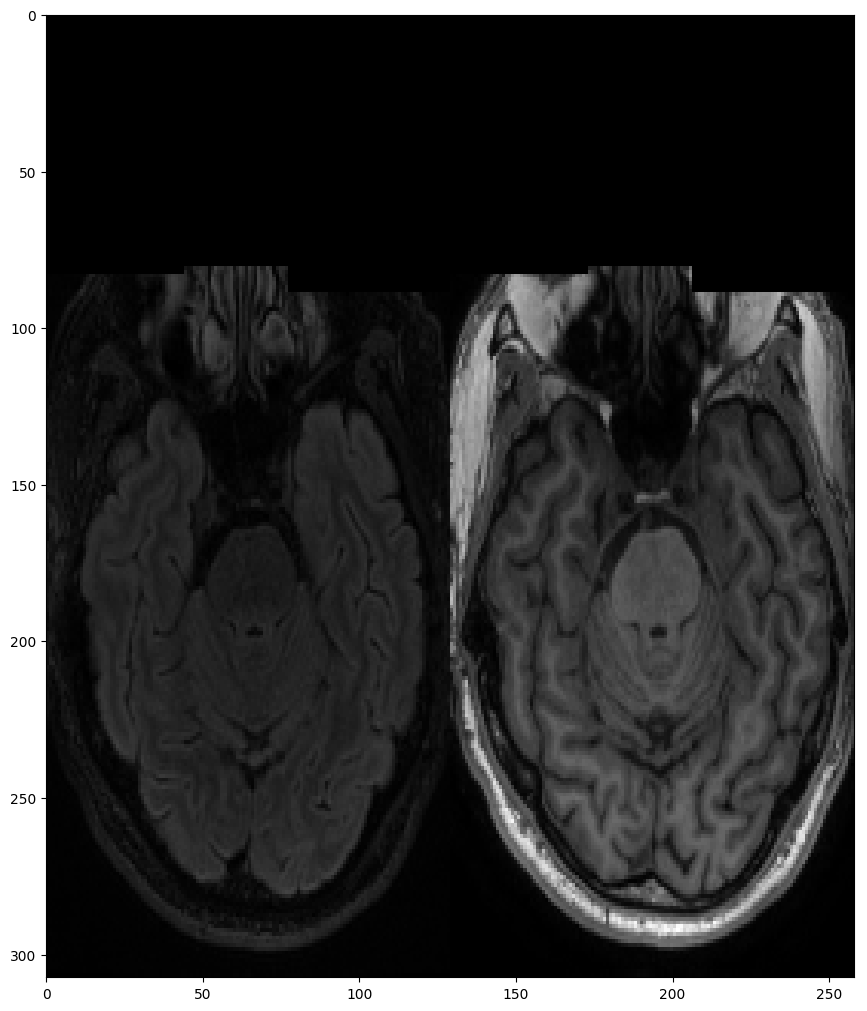

In [14]:
myshow(sitk.Tile(imgT1Original[:, :, 30],
                         imgT2Original[:, :, 30],
                         (2, 1, 0)))

In [15]:
help(sitk.Tile)

Help on function Tile in module SimpleITK.SimpleITK:

Tile(*args)
    Tile(VectorOfImage images, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, Image image3, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, Image image3, Image image4, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, Image image3, Image image4, Image image5, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image



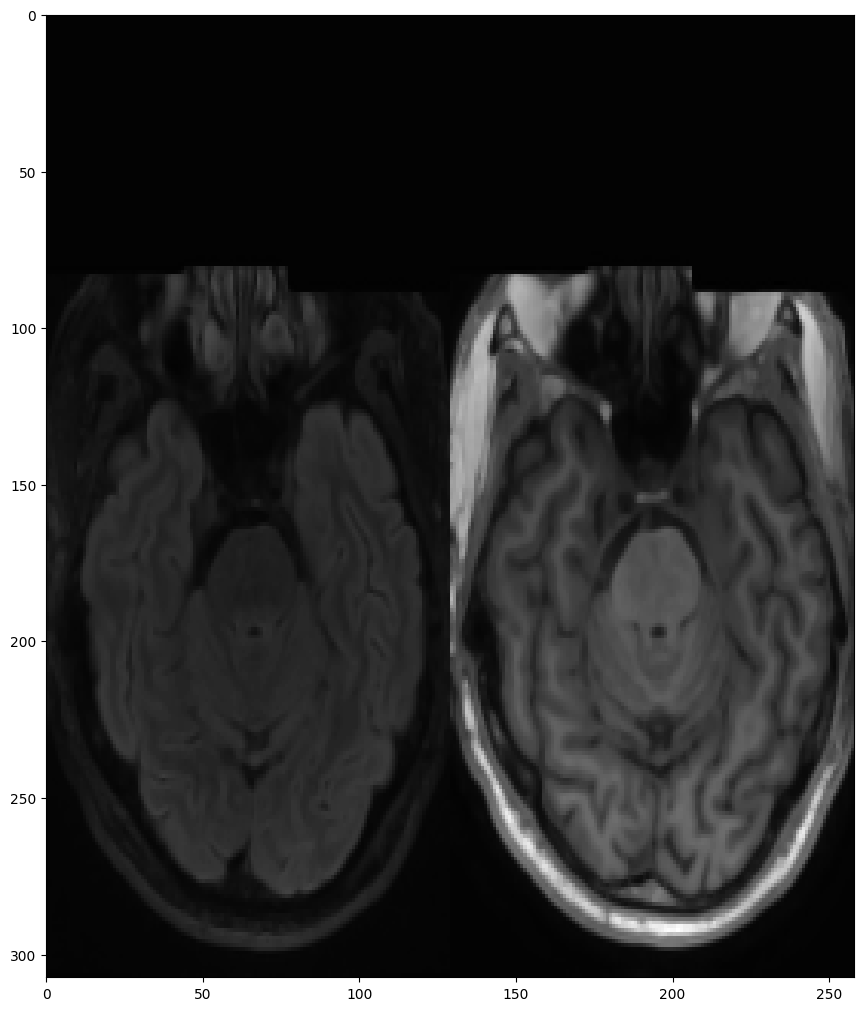

In [16]:
imgT1Smooth = sitk.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgT2Smooth = sitk.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

myshow(sitk.Tile(imgT1Smooth[:, :, 30], 
                         imgT2Smooth[:, :, 30], 
                         (2, 1, 0)))

In [17]:
help(sitk.CurvatureFlow)

Help on function CurvatureFlow in module SimpleITK.SimpleITK:

CurvatureFlow(image1, timeStep=0.05, numberOfIterations=5)
    CurvatureFlow(Image image1, double timeStep=0.05, uint32_t numberOfIterations=5) -> Image
    
    
    
    Denoise an image using curvature driven flow.
    
    
    This function directly calls the execute method of CurvatureFlowImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::CurvatureFlowImageFilter for the object oriented interface



In [18]:
print(flairImage)

Image (0x7ff48bfa79a0)
  RTTI typeinfo:   itk::Image<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 963
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 941
  UpdateMTime: 962
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [132, 256, 83]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [132, 256, 83]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1, 256, 83]
  Spacing: [1.2, 0.9766, 3]
  Origin: [-80.0952, -169.878, -129.121]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1.2 0 0
0 0.9766 0
0 0 3

  PointToIndexMatrix: 
0.833333 0 0
0 1.02396 0
0 0 0.333333

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x7ff48bfa76b0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned short>
  

In [19]:
print(type(flairImage))

<class 'SimpleITK.SimpleITK.Image'>


In [20]:
sitk.Show(flairImage)

sitk.Show(resultImage)

In [21]:
n = sitk.GetArrayFromImage(flairImage)
n.shape

(83, 256, 132)

In [22]:
n.shape[0]//2

41

In [44]:
def myshow(img, title=None, margin=0.05, dpi=100):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (4 + margin) * ysize / dpi, (4 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
   
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [24]:
list(range(0, size[2], size[2]//10))


NameError: name 'size' is not defined

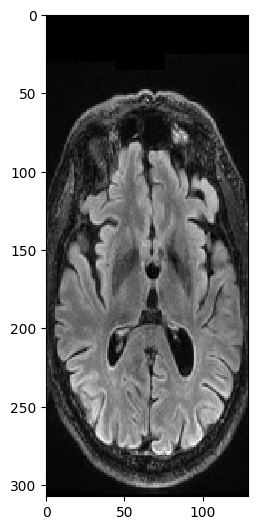

In [25]:
myshow(flairImage)

(132, 256, 83)
11


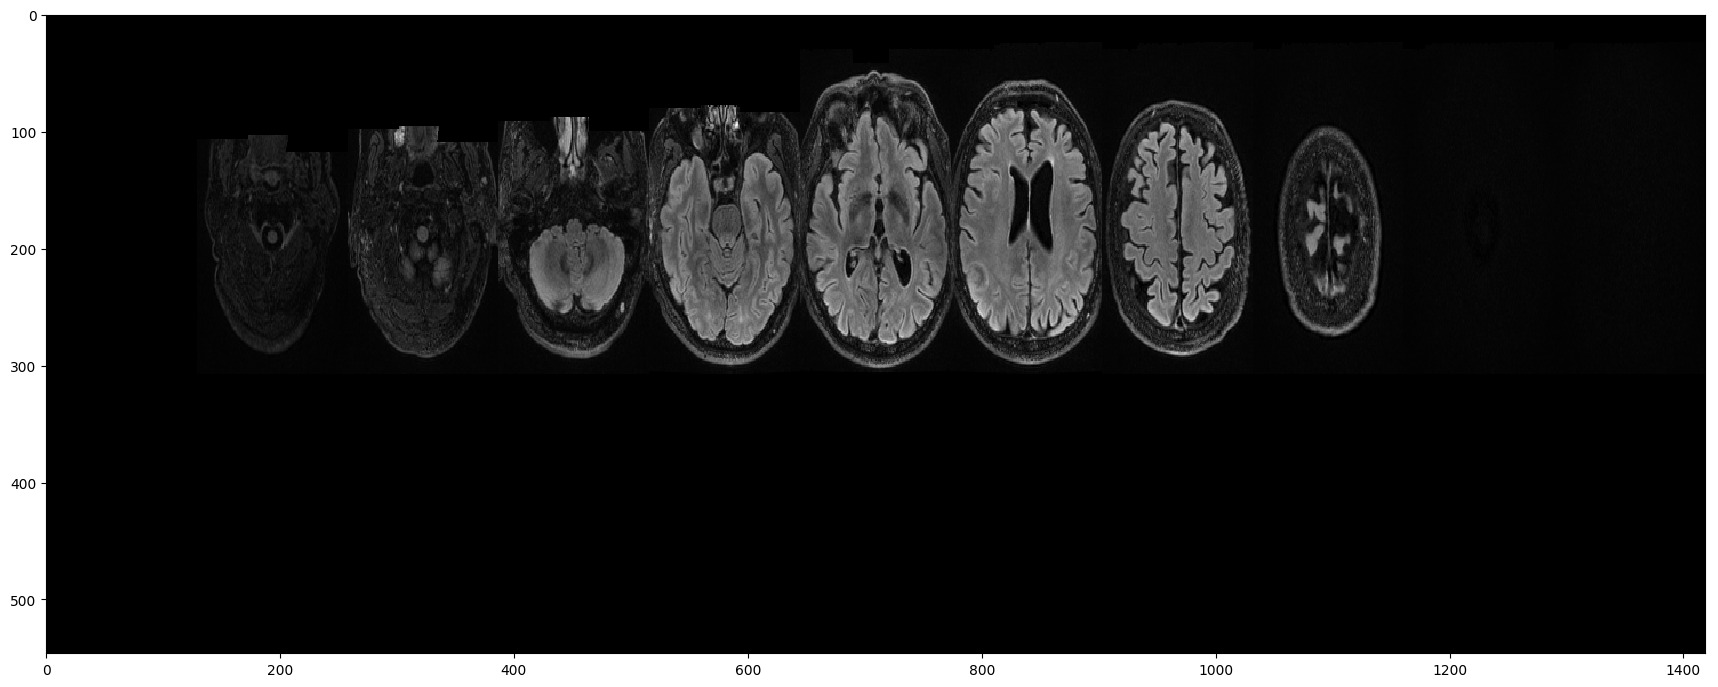

In [26]:

size = flairImage.GetSize()
print(size)
nslices = 3
slices = [ flairImage[:,:,s] for s in range(0, size[2], size[2]//10)]

print(len(slices))

myshow(sitk.Tile(slices, [11,200]))


In [27]:
help(sitk.Tile)

Help on function Tile in module SimpleITK.SimpleITK:

Tile(*args)
    Tile(VectorOfImage images, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, Image image3, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, Image image3, Image image4, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image
    Tile(Image image1, Image image2, Image image3, Image image4, Image image5, VectorUInt32 layout, double defaultPixelValue=0.0) -> Image



# Preprocessing 

## 1. select slice  
### remove 1/8 from both begining and the end for all folder

In [28]:
selectimage = [ flairImage[:,:,s] for s in range(size[2]//8,size[2]-size[2]//8)]

In [29]:
len(selectimage)

63

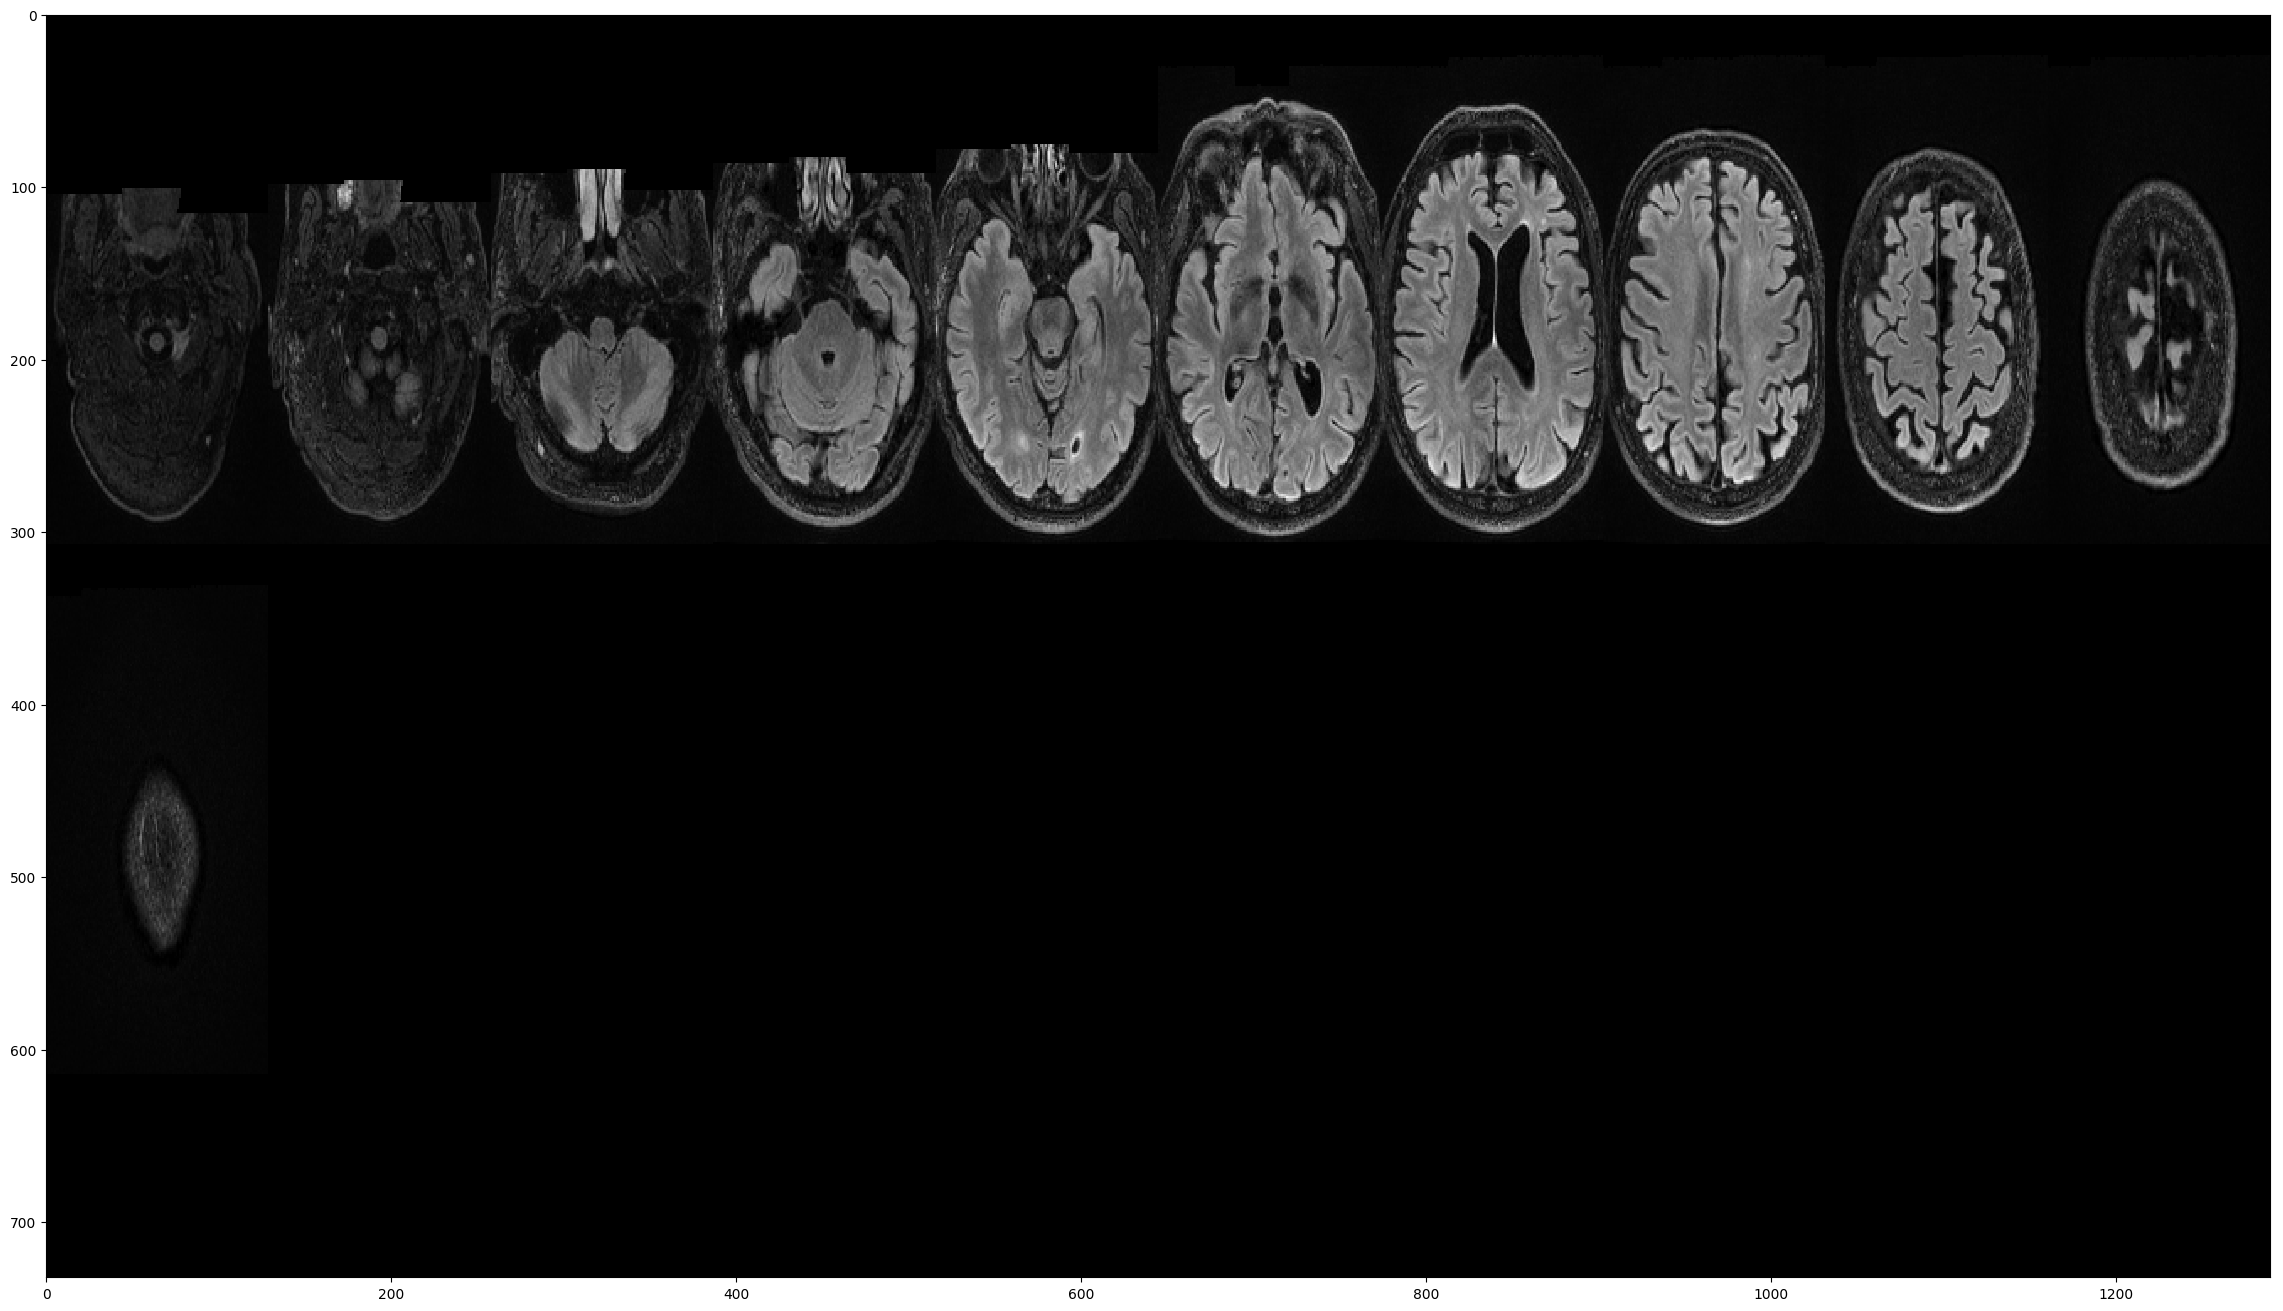

In [30]:
slices2 = [selectimage[s] for s in range(0,len(selectimage),len(selectimage)//10)]
myshow(sitk.Tile(slices2, [10,100]))


In [31]:
only use target have something

SyntaxError: invalid syntax (<ipython-input-31-a115e3b19340>, line 1)

## 2. masking the brain?

(132, 256, 83)


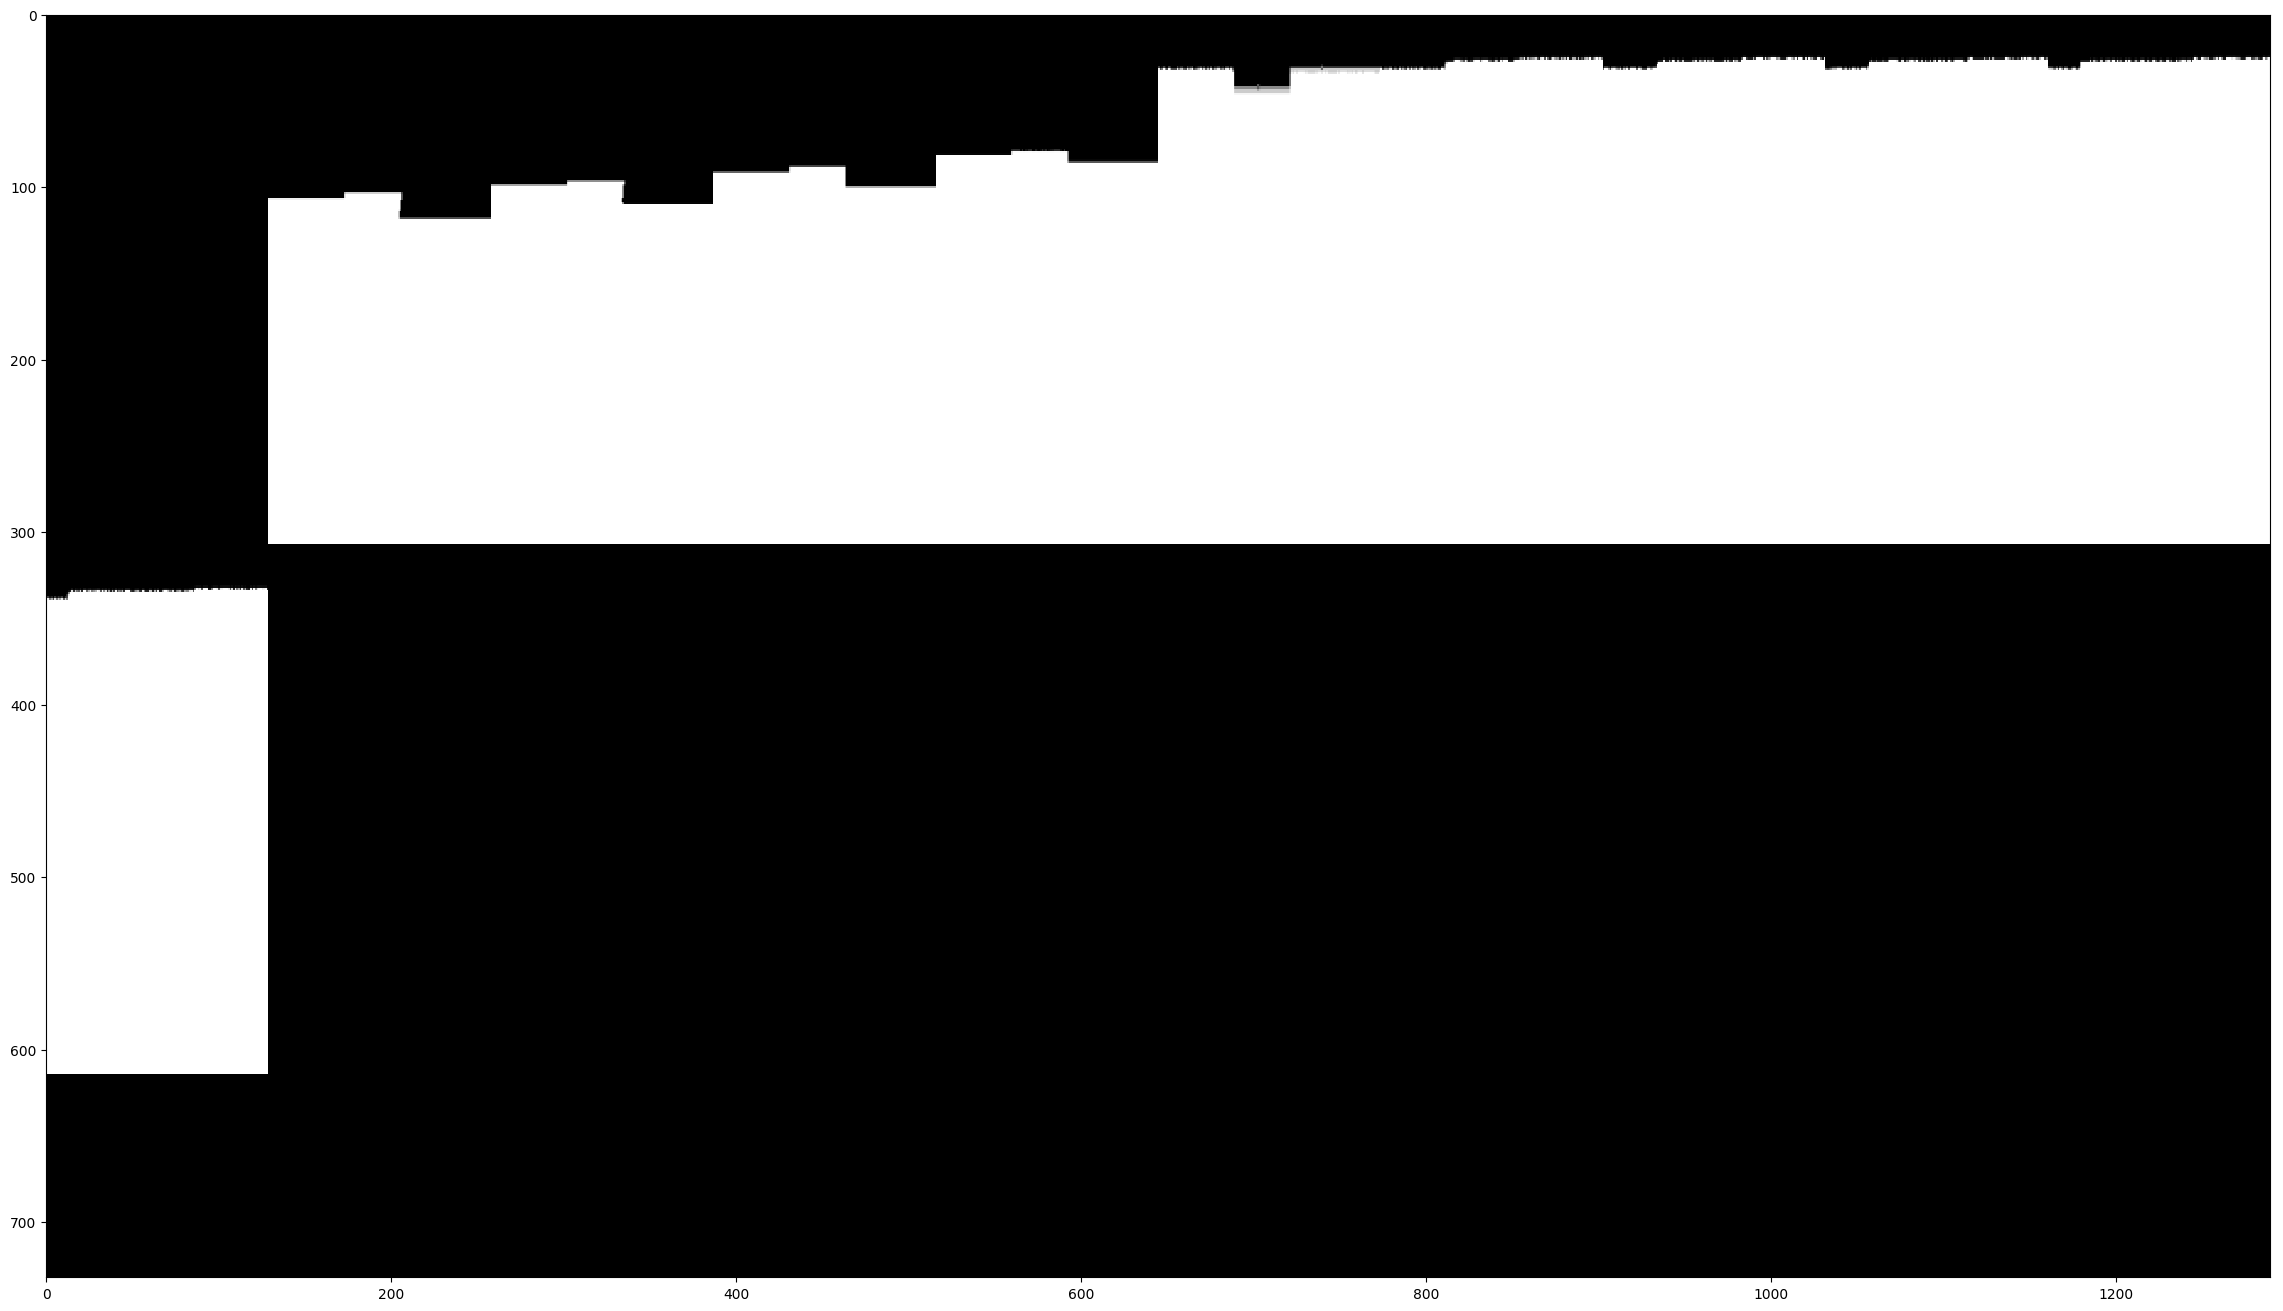

In [32]:
imgt1maskOriginal = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR_mask.nii.gz'))
size = imgt1maskOriginal.GetSize()
print(size)
nslices = 3
slices = [ imgt1maskOriginal[:,:,s] for s in range(0, size[2], size[2]//10)]
myshow(sitk.Tile(slices, [10,100]))

In [33]:
imgT1Smooth30 = imgT1Smooth[:,:,30]

In [34]:
labelWhiteMatter = 1
labelGrayMatter = 2
lstSeeds = [(22,155)]

imgWhiteMatter = sitk.ConnectedThreshold(image1=imgT1Smooth30, 
                                              seedList=lstSeeds, 
                                              lower=500, 
                                              upper=700,
                                              replaceValue=labelWhiteMatter)

In [35]:
sitk.Show(imgT1Smooth30)

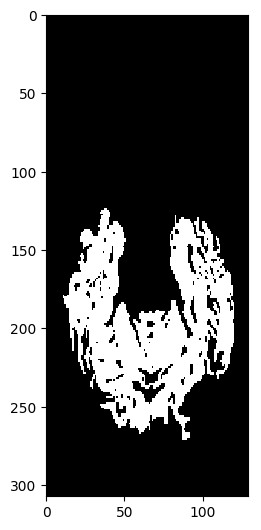

In [36]:
myshow(imgWhiteMatter)

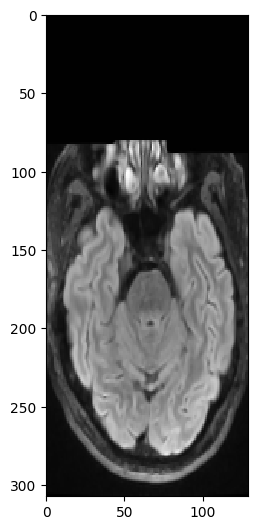

In [37]:
myshow(imgT1Smooth30)

In [38]:
help(sitk.ConnectedThreshold)

Help on function ConnectedThreshold in module SimpleITK.SimpleITK:

ConnectedThreshold(*args, **kwargs)
    ConnectedThreshold(Image image1, VectorUIntList seedList, double lower=0, double upper=1, uint8_t replaceValue=1, itk::simple::ConnectedThresholdImageFilter::ConnectivityType connectivity) -> Image
    
    
    
    itk::simple::ConnectedThresholdImageFilter Functional Interface
    
    This function directly calls the execute method of ConnectedThresholdImageFilter in order to support a fully functional API



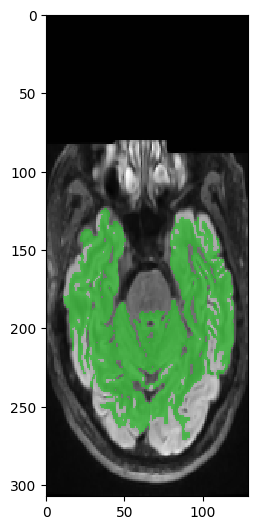

In [39]:
# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSmoothInt = sitk.Cast(sitk.RescaleIntensity(imgT1Smooth30), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
myshow(sitk.LabelOverlay(imgSmoothInt, imgWhiteMatter))

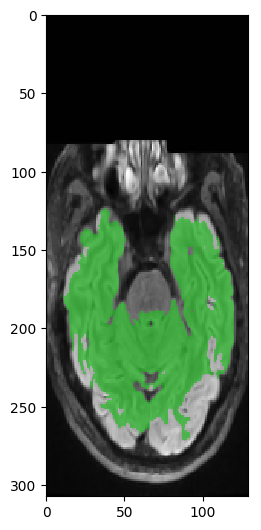

In [40]:
imgWhiteMatterNoHoles = sitk.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)

myshow(sitk.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))


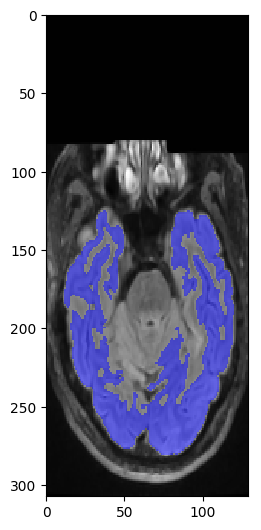

In [41]:
lstSeeds = [(18, 181), (79, 231), (93, 106), (110, 195)]

imgGrayMatter = sitk.ConnectedThreshold(image1=imgT1Smooth30, 
                                             seedList=lstSeeds, 
                                             lower=600, 
                                             upper=970,
                                             replaceValue=labelGrayMatter)

imgGrayMatterNoHoles = sitk.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

myshow(sitk.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

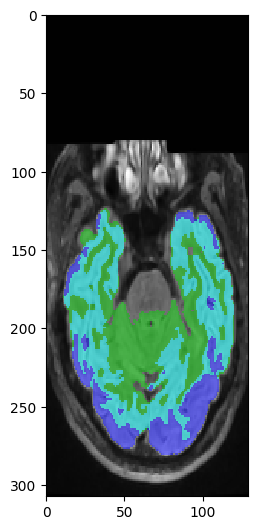

In [42]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles

myshow(sitk.LabelOverlay(imgSmoothInt, imgLabels))

In [43]:
imgWhiteMatterNoHoles.GetSize()

(132, 256)

In [44]:
imgGrayMatterNoHoles.GetSize()

(132, 256)

In [45]:
labelGrayMatter

2

In [46]:
imgWhiteMatterNoHoles.GetSize(), labelWhiteMatter, imgGrayMatterNoHoles.GetSize(), labelGrayMatter

((132, 256), 1, (132, 256), 2)

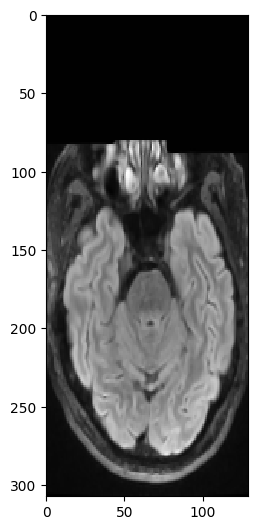

In [47]:
myshow(imgT1Smooth30)

In [48]:
sitk.GetArrayFromImage(imgT1Smooth30).shape

(256, 132)

In [49]:
(imgGrayMatterNoHoles/labelGrayMatter).GetSize()

(132, 256)

In [50]:
help(sitk.GetArrayFromImage)

Help on function GetArrayFromImage in module SimpleITK.SimpleITK:

GetArrayFromImage(image)
    Get a NumPy ndarray from a SimpleITK Image.
    
    This is a deep copy of the image buffer and is completely safe and without potential side effects.



In [51]:
imgWhiteMatterNoHoles.GetSize()

(132, 256)

In [52]:
sum(sum(sitk.GetArrayFromImage(imgWhiteMatterNoHoles) == 1)), sum(sum(sitk.GetArrayFromImage(imgGrayMatterNoHoles) == 2))

(7354, 5764)

In [53]:
imgLables = (imgWhiteMatterNoHoles + imgGrayMatterNoHoles) >0

In [54]:
sum(sum(sitk.GetArrayFromImage(imgLables) == 1)), sum(sum(sitk.GetArrayFromImage(imgLables) == 2))

(9145, 0)

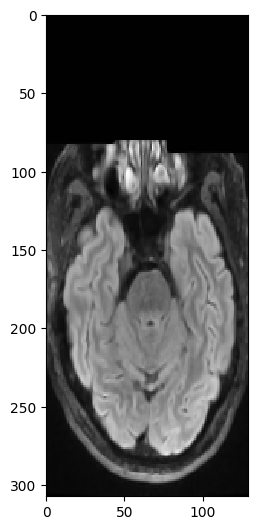

In [55]:
myshow(imgSmoothInt)

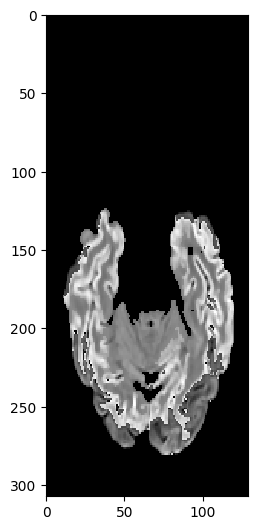

In [56]:
myshow(imgSmoothInt * imgLabels)

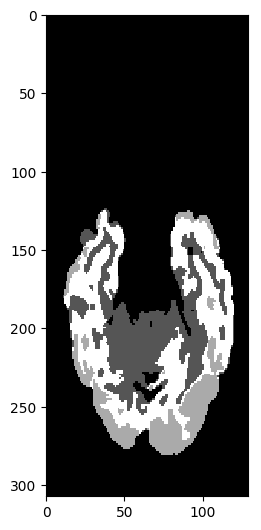

In [57]:
myshow(imgLabels)

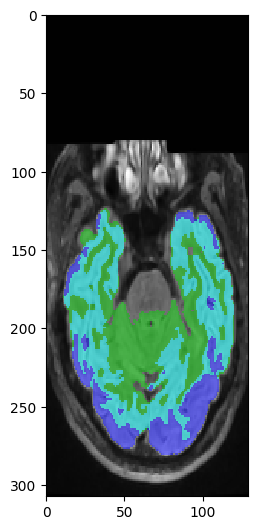

In [58]:
myshow(sitk.LabelOverlay(imgSmoothInt, imgLabels))

In [59]:
imgMask= (imgWhiteMatterNoHoles/labelWhiteMatter) * (imgGrayMatterNoHoles/labelGrayMatter)

In [60]:
(imgMask*labelWhiteMatter).GetSize()

(132, 256)

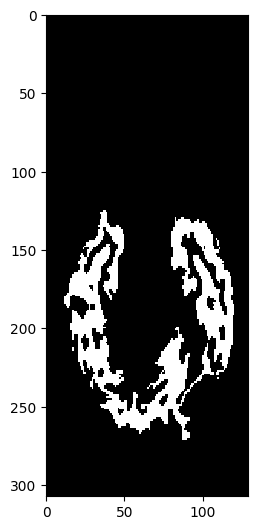

In [61]:
myshow(imgMask)

In [62]:
imgWhiteMatterNoHoles.GetSize()

(132, 256)

In [63]:
imgWhiteMatterNoHoles = sitk.GetImageFromArray(sitk.GetArrayFromImage(imgWhiteMatterNoHoles) -
                                   sitk.GetArrayFromImage(imgMask*labelWhiteMatter)
                                  )

In [64]:
imgWhiteMatterNoHoles.GetSize()

(132, 256)

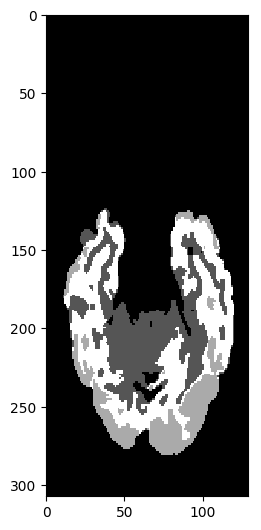

In [65]:
myshow(imgLabels)

In [66]:
import cv2

In [67]:
rect = cv2.boundingRect(sitk.GetArrayFromImage(imgLabels))             # function that computes the rectangle of interest
print(rect)
cropped_img = imgSmoothInt[rect[0]:(rect[0]+rect[2]), rect[1]:(rect[1]+rect[3])]  # crop the image to the desired rectangle 

(11, 103, 112, 131)


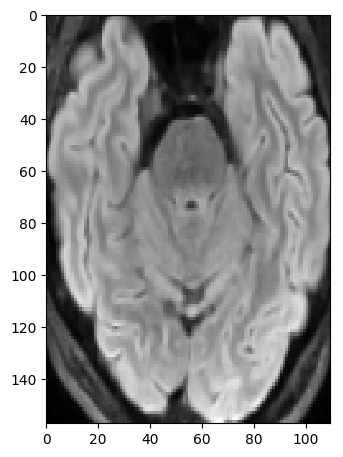

In [68]:
myshow(cropped_img)

In [69]:
info = np.iinfo(data.dtype) # Get the information of the incoming image type
data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
data = 255 * data # Now scale by 255
img = data.astype(np.uint8)
cv2.imshow("Window", img)

NameError: name 'data' is not defined

In [70]:
imgWhiteMatterNoHoles = sitk.GetImageFromArray(sitk.GetArrayFromImage(imgWhiteMatterNoHoles).astype(np.float64))
imgGrayMatterNoHoles = sitk.GetImageFromArray(sitk.GetArrayFromImage(imgGrayMatterNoHoles).astype(np.float64))


In [71]:
sitk.GetArrayFromImage(imgGrayMatterNoHoles).dtype

dtype('float64')

In [72]:
imgLabels = imgWhiteMatterNoHoles/labelWhiteMatter + imgGrayMatterNoHoles/labelGrayMatter

sitk.Show(sitk.LabelOverlay(imgSmoothInt, imgLabels))

RuntimeError: Exception thrown in SimpleITK LabelOverlay: /scratch/dashboard/SimpleITK-OSX10.6-x86_64-pkg/SimpleITK/Code/Common/include/sitkDualMemberFunctionFactory.hxx:214:
sitk::ERROR: Pixel type: 8-bit unsigned integer is not supported in 2D byN3itk6simple23LabelOverlayImageFilterE

In [ ]:
help(sitk.ConnectedThreshold)

In [73]:
from nipype.interfaces import fsl

/Users/jingqin/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [74]:
from nipype.testing import example_data

In [75]:
sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR.nii.gz'))

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1164dcdb0> >

In [61]:
from nipype.interfaces import fsl
btr = fsl.BET()
btr.inputs.in_file = os.path.join(inputDir, 'orig', 'FLAIR.nii.gz')

btr.inputs.frac = 0.7
btr.inputs.out_file = 'brain_anat.nii'
btr.cmdline
#res = btr.run() 

/Users/jingqin/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


180718-09:26:36,887 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


'bet data/train/Amsterdam/101/orig/FLAIR.nii.gz brain_anat.nii -f 0.70'

In [65]:
btr.run()

OSError: No command "bet" found on host Jings-MacBook-Air.local. Please check that the corresponding package is installed.

In [63]:
help(bet)

NameError: name 'bet' is not defined

## 3. crop and pad

In [3]:
flairImage = sitk.ReadImage(os.path.join(inputDir, 'orig', 'FLAIR.nii.gz'))


In [7]:
flairImage[:,:,40].GetSize()

(132, 256)

In [14]:
 ((256-132) // 2 , (256-132) // 2 )

(62, 62)

In [18]:
sitk.GetArrayFromImage(flairImage[:,:,40])

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [16, 19, 19, ..., 18, 16, 22],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16)

In [40]:
img = flairImage[:,:,40]

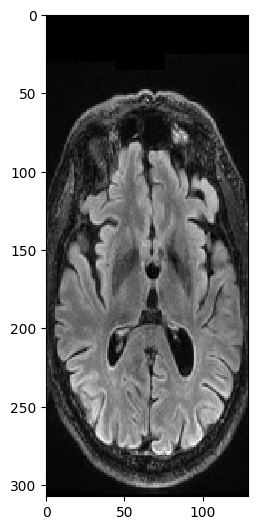

In [55]:
myshow(flairImage)

In [58]:
img2 = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(0,0),((256-132) // 2 , (256-132) // 2 )], 'constant')

In [59]:
img2.shape

(83, 256, 256)

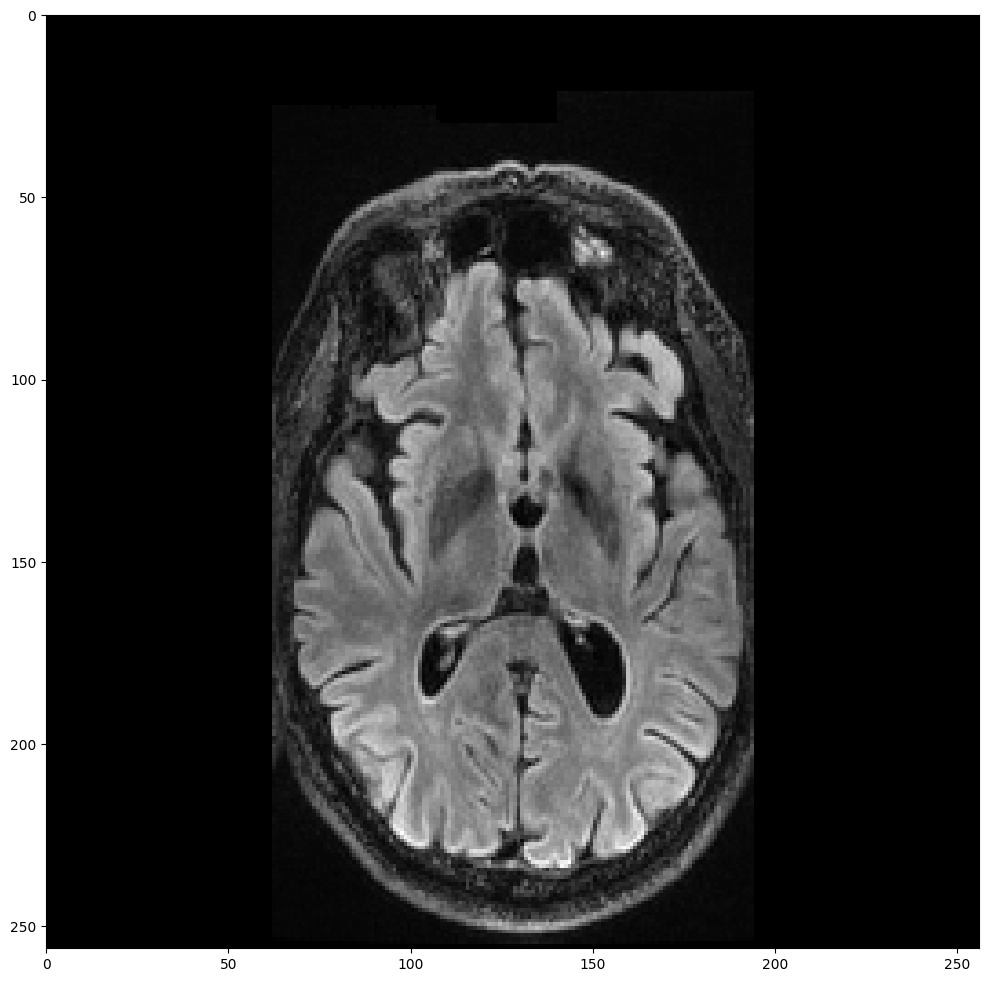

In [60]:
myshow(sitk.GetImageFromArray(img2))

In [36]:
def padwithzero(vector, pad_width, iaxis, kwargs):
    print("vector, pad_width, iaxis, kwargs",vector, pad_width, iaxis, kwargs)
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector
padding = 0

x = np.array([[1,2],[3,4],[5,6]])
print(x.shape)
tmp_mainImg = np.pad(x,[(0,0),(3,2)], 'constant')
print(tmp_mainImg)


(3, 2)
[[0 0 0 1 2 0 0]
 [0 0 0 3 4 0 0]
 [0 0 0 5 6 0 0]]


## 4. voxel intensity normalizarion per patient

## 5. data augmentation

In [ ]:
generater function 
